In [1]:
import sys
sys.path.insert(1, '../')


In [2]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)


<module 'medical_explainer' from '/home/llja/repos/Uni_ACS/mimiciv_sepsis/../medical_explainer.py'>

In [3]:
import pandas as pd
data = pd.read_csv('mimiciv_sepsis.csv').drop(['testtrain', 'hadm_id'], axis=1)

data['gender'] = data['gender'].apply(lambda x: 1 if x == 'M' else 0)

data = pd.concat([data, pd.get_dummies(data['marital_status'], prefix='marital_status')], axis=1)
data = data.drop(['marital_status'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ethnicity'], prefix='ethnicity')], axis=1)
data = data.drop(['ethnicity'], axis=1)

data = pd.concat([data, pd.get_dummies(data['insurance'], prefix='insurance')], axis=1)
data = data.drop(['insurance'], axis=1)

data = pd.concat([data, pd.get_dummies(data['ed_medgp_antibiotic_hrgp'], prefix='antibiotic')], axis=1)
data = data.drop(['ed_medgp_antibiotic_hrgp'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split

seed = 7

X = data.drop(['icu_adm_flag', 'hosdeath_flag'], axis=1)
y = data['icu_adm_flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=seed)


In [5]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_train)

X_train = pd.DataFrame(imp.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns=X.columns)

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

estimators = [('Scaler', StandardScaler()), ('Log_Reg', LogisticRegression(random_state=seed, solver='liblinear'))]
pipe = Pipeline(estimators)

clf = pipe.fit(X_train, y_train)


In [7]:
import importlib
import medical_explainer
importlib.reload(medical_explainer)

<module 'medical_explainer' from '/home/llja/repos/Uni_ACS/mimiciv_sepsis/../medical_explainer.py'>

| Step 1  ==> Calibrating model


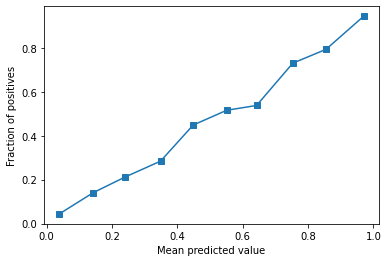

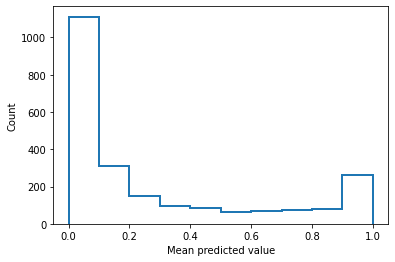

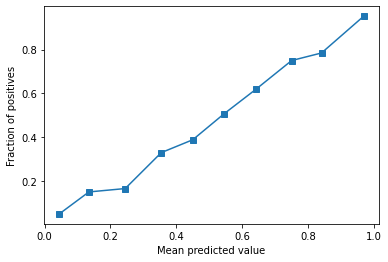

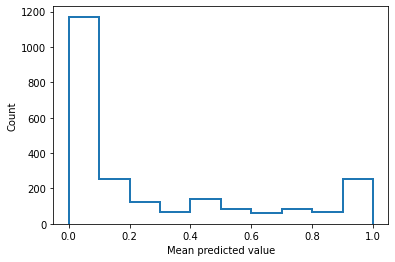

ROC AUC: 0.9034542474858025
Average Precision: 0.8193843407272192
Accuracy: 0.8677936714347637
ROC AUC: 0.9025845684609053
Average Precision: 0.8262364811355299
Accuracy: 0.8686605981794538

| Step 2 ==> Calculate SHAP values

| Step 3 ==> Fit clinical score calculator
Novel fitting


Probability threshold: 0.1
Score threshold: 37.0

Probability threshold: 0.5
Score threshold: 51.0

Probability threshold: 0.9
Score threshold: 66.0



In [8]:
explainer = medical_explainer.explainer(
    clf, X_train, y_train, X_test, y_test)

explainer.fit(10, shap_method='linear', method='novel')

In [9]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.861591579003274
Average Precision: 0.7570428443754917
Accuracy: 0.8387516254876463
[[1599   80]
 [ 292  336]]


In [11]:
explainer.shap_array_list

[[0.4597390061131702, -0.5313925633766982],
 [-0.20577146133396762, 1.8519431520057092],
 [0.3001896253568303, -0.3321618455996633],
 [0.1491241936928849, -3.5789806486292357],
 [-0.17150110991869305, 0.3819769005849627],
 [0.255627930109567, -0.2520566407443048],
 [-0.11286131474852615, 0.6932909334552319],
 [-0.11639437810667344, 0.6595681426044828],
 [-0.10821178814208363, 0.3836599761401147],
 [-0.1500842390834962, 0.18270123936675026]]

In [12]:
explainer.score_array_list

[array([ 3., -4.]),
 array([-1., 12.]),
 array([ 2., -2.]),
 array([  1., -24.]),
 array([-1.,  3.]),
 array([ 2., -2.]),
 array([-1.,  5.]),
 array([-1.,  4.]),
 array([-1.,  3.]),
 array([-1.,  1.])]

In [13]:
explainer.variables

array(['edvital_sbp_median', 'time2bg_24hr_flag', 'fbc24hr_rbc_first',
       'ed_a_nitrofurantoin_monohy__macrobid', 'edvital_resprate_median',
       'fbc24hr_mch_first', 'ed_medgp_cardiovascular',
       'antibiotic_a_lesse1', 'ed_a_vancomycin',
       'edvital_heartrate_median'], dtype=object)

In [14]:
explainer.breakpoints_list

[[10.0, 125.05373601189802, 212.0],
 [0.0, 0.10815275959599945, 1.0],
 [0.86, 3.6150961182465324, 7.34],
 [0.0, 0.049769920880252, 1.0],
 [9.5, 18.322766566328212, 62.0],
 [16.2, 29.65803730180259, 45.3],
 [0.0, 0.14734789155197583, 1.0],
 [0.0, 0.15714341892444772, 1.0],
 [0.0, 0.2257142827839191, 1.0],
 [39.0, 85.67203822046251, 174.0]]

In [15]:
scores,probs,predictions = explainer.predict_calculator(X_test, 1)

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

roc_auc = roc_auc_score(y_test, probs)
print("ROC AUC: " + str(roc_auc))

average_precision = average_precision_score(y_test, probs)
print("Average Precision: " + str(average_precision))

# accuracy = accuracy_score(y_test, predictions)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: " + str(accuracy))

# print(confusion_matrix(y_test, predictions))
print(confusion_matrix(y_test, predictions))


ROC AUC: 0.861591579003274
Average Precision: 0.7570428443754917
Accuracy: 0.8387516254876463
[[1599   80]
 [ 292  336]]


In [17]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [18]:
y_test = y_test.reset_index(drop=True)

In [19]:
from sklearn.utils import resample

auroc_array = []
auprc_array = []
accuracy_array = []

for i in range(50):
    X_test_bs = resample(X_test, n_samples=200, replace=False, stratify=y_test,
             random_state=i)
    y_test_bs = y_test[X_test_bs.index]

    scores,probs,predictions = explainer.predict_calculator(X_test_bs, 1)
    auroc = roc_auc_score(y_test_bs, probs)
    auprc = average_precision_score(y_test_bs, probs)
    accuracy = accuracy_score(y_test_bs, predictions)
    
    auroc_array.append(auroc)
    auprc_array.append(auprc)
    accuracy_array.append(accuracy)
    

print(mean_confidence_interval(auroc_array))
print(mean_confidence_interval(auprc_array))
print(mean_confidence_interval(accuracy_array))

(0.8571626078132928, 0.8465104490451792, 0.8678147665814063)
(0.7473904057976344, 0.7304910712581987, 0.7642897403370701)
(0.8351, 0.8282250561628924, 0.8419749438371075)
